In [29]:

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.problems.functional import FunctionalProblem

from tqdm import tqdm


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay


from utils import plot_proba

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Tuple, Optional

### Data-Generating Process

Let $(\mathcal X,\Sigma_{\mathcal X})$ be the measurable input (feature) space and $(\mathcal Y,\Sigma_{\mathcal Y})$ the measurable output (target) space. Define the product space
$$
(\mathcal Z,\Sigma_{\mathcal Z}) := (\mathcal X\times\mathcal Y,\; \Sigma_{\mathcal X}\otimes \Sigma_{\mathcal Y}).
$$
The supervised learning problem is governed by an **unknown** probability measure
$$
P \in \mathcal P(\mathcal Z)
$$
on $(\mathcal Z,\Sigma_{\mathcal Z})$, called the *data-generating distribution*.
In ML notation we often write $\mathcal D := P$ and $(X,Y)\sim \mathcal D$.

---

### Assumption (i.i.d. sample)

Training data are obtained as $n$ i.i.d. draws from $P$ (equivalently $\mathcal D$):
$$
Z_i=(X_i,Y_i)\stackrel{\text{i.i.d.}}{\sim} P,\qquad i=1,\dots,n.
$$
This yields the dataset
$$
S \equiv D_n = \{(x_i,y_i)\}_{i=1}^n \in \mathcal Z^n, \qquad S\sim P^n=\mathcal D^n.
$$

---

### Marginal and Conditional Structure

Let $P_X$ (or $\mathcal D_X$) be the marginal of $P$ on $\mathcal X$:
$$
P_X(A)=P(A\times \mathcal Y),\qquad A\in\Sigma_{\mathcal X}.
$$
Assume a (regular) conditional distribution $P_{Y\mid X}(\cdot\mid x)\in\mathcal P(\mathcal Y)$ exists such that for all measurable $A\subseteq\mathcal X$ and $B\subseteq\mathcal Y$,
$$
P(A\times B)=\int_A P_{Y\mid X}(B\mid x)\,P_X(dx).
$$
When densities exist, this corresponds to the factorization
$$
p(x,y)=p_X(x)\,p_{Y\mid X}(y\mid x).
$$
Equivalently, sampling can be viewed as
$$
X_i\sim P_X,\qquad Y_i\sim P_{Y\mid X}(\cdot\mid X_i).
$$


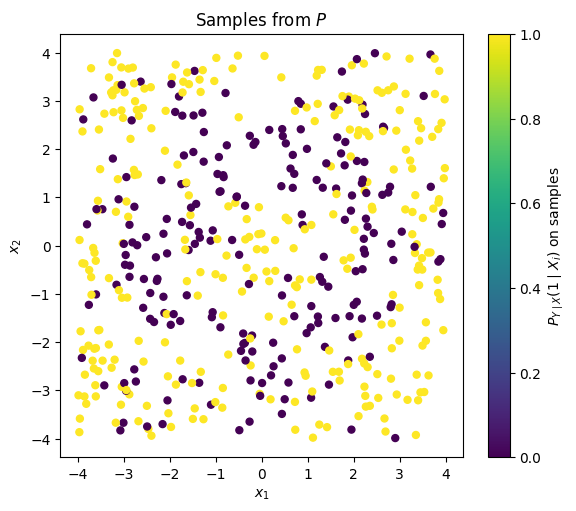

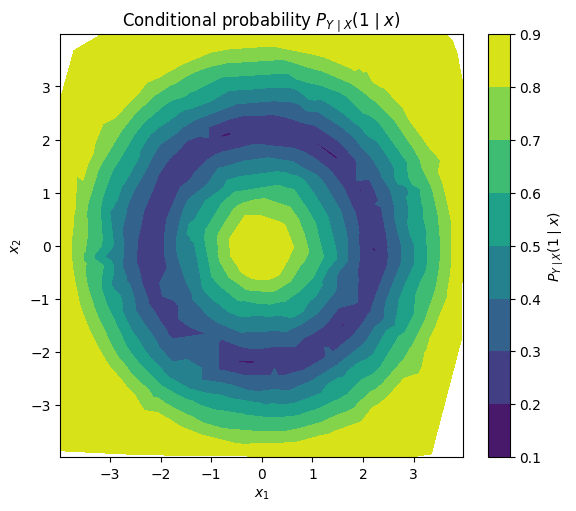

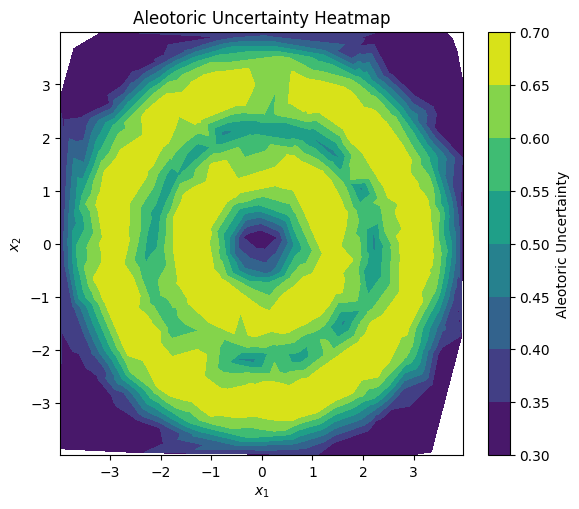

In [77]:
import numpy as np
from functools import partial
from typing import Callable, Tuple, Optional

# p(x) = P_{Y|X}(1|x)  (vectorized)
def boundary_focus_prob(
    X: np.ndarray,
    r_inner=np.sqrt(2), r_outer=3.0,
    sigma=0.85, # controls how fast uncertainty decays away from boundary
    max_uncertainty=0.89
) -> np.ndarray:
    X = np.asarray(X)
    r = np.linalg.norm(X, axis=-1)

    base = ((r <= r_inner) | (r >= r_outer)).astype(float)
    dist_to_boundary = np.minimum(np.abs(r - r_inner), np.abs(r - r_outer))
    alpha = max_uncertainty * np.exp(-(dist_to_boundary / sigma) ** 2)

    p1 = base * (1 - alpha) + 0.5 * alpha
    return np.clip(p1, 0.0, max_uncertainty)

def Aleotoric_Uncertainty_prob(
    p_fn # callable that maps X to P_{Y|X}(1|x)
) -> Callable[[np.ndarray], np.ndarray]:
    def wrapped_fn(X: np.ndarray) -> np.ndarray:
        p1 = p_fn(X)
        p0 = 1.0 - p1
        uncertainty = -np.sum(np.stack([p0, p1], axis=-1) * np.log(np.stack([p0, p1], axis=-1) + 1e-12), axis=-1)
        return uncertainty
    return wrapped_fn

def dpg(
    n: int,# number of samples
    x_sampler: Callable[..., np.ndarray],  # represents P_X
    p_fn: Callable[[np.ndarray], np.ndarray], # represents P_{Y|X}(1|x)
    d: int = 2, # number of features
    rng: Optional[np.random.Generator] = None, 
    x_sampler_kwargs: Optional[dict] = None,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    X_i ~ P_X via x_sampler
    Y_i | X_i ~ Bernoulli(p_fn(X_i)) via numpy rng.binomial
    """
    rng = np.random.default_rng() if rng is None else rng
    x_sampler_kwargs = {} if x_sampler_kwargs is None else dict(x_sampler_kwargs)

    if "size" not in x_sampler_kwargs:
        x_sampler_kwargs["size"] = (n, d)

    X = np.asarray(x_sampler(**x_sampler_kwargs))
    p1 = np.clip(p_fn(X), 0.0, 1.0)
    Y = rng.binomial(1, p1).astype(np.int64)
    return X, Y, p1



rng = np.random.default_rng(42)
x_sampler = partial(rng.uniform, low=-4, high=4)   # P_X

X, Y, p1 = dpg(
    n=500,
    x_sampler=x_sampler,
    p_fn=boundary_focus_prob,
    d=2,
    rng=rng
)




plt.figure(figsize=(6.5, 5.5))
plt.scatter(X[:, 0], X[:, 1],c=Y ,s=25, cmap="viridis")
plt.colorbar(label=r"$P_{Y\mid X}(1\mid X_i)$ on samples")
plt.title("Samples from $P$ ")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# use plt to generate heatmap of p1
plt.figure(figsize=(6.5, 5.5))
plt.tricontourf(X[:, 0], X[:, 1], p1, levels=7, cmap="viridis")
plt.colorbar(label=r"$P_{Y\mid X}(1\mid x)$")
plt.title("Conditional probability $P_{Y\mid X}(1\mid x)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


# AU_heatmap
AU_values = Aleotoric_Uncertainty_prob(boundary_focus_prob)(X)
plt.figure(figsize=(6.5, 5.5))
plt.tricontourf(X[:, 0], X[:, 1], AU_values, levels=7, cmap="viridis")
plt.colorbar(label=r"Aleotoric Uncertainty")
plt.title("Aleotoric Uncertainty Heatmap")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()


In [63]:


# -----------------------------
# 2) Train classifier
# -----------------------------


device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        torch.tensor(Y, dtype=torch.long))
# X, Y = sklearn.datasets.make_moons(n_samples=300, noise=0.1, random_state=42)
# X = torch.tensor(X, dtype=torch.float32)
# Y = torch.tensor(Y, dtype=torch.long)
# dataset = TensorDataset(X, Y)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 16), nn.ReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.net(x)


model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [66]:
# training loop
num_epochs = 150

bar = tqdm(range(num_epochs), desc="Training", ncols=80, unit="epoch",colour="blue")
for epoch in bar:
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    bar.set_postfix({'Train Loss': epoch_loss})

# Validation
model.eval()
val_loss = 0.0
correct = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

val_loss /= len(val_loader.dataset)
val_accuracy = correct / len(val_loader.dataset)

bar.set_postfix({'Train Loss': epoch_loss, 'Val Loss': val_loss, 'Val Acc': val_accuracy})


Training: 100%|██████████| 150/150 [00:06<00:00, 24.55epoch/s, Train Loss=0.485]


(<Figure size 520x460 with 2 Axes>,
 <Axes: title={'center': 'Class 1 probability surface'}, xlabel='x0', ylabel='x1'>)

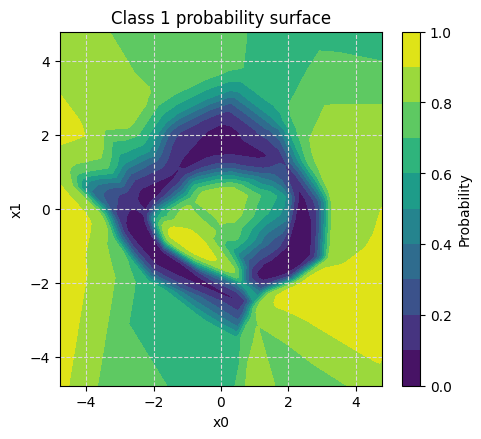

In [67]:
# visual

plot_proba(model, X,levels=10)


Let $X$ be the feature space and $X_{\mathrm{obs}} \subseteq X$ the set of observed (factual) instances.
A candidate counterfactual is denoted by $\bar{x} \in X^{CF} \subseteq X$, where $X^{CF}$ is the feasible
counterfactual search space. The original (factual) instance is $x^\ast \in X_{\mathrm{obs}}$.
Each instance $x \in X$ has $p=\dim(x)$ features, written as
$x=(x_1,\dots,x_p)$ and $\bar{x}=(\bar{x}_1,\dots,\bar{x}_p)$.
Let $\hat{f}:X\to Y$ be the trained prediction model with output space $Y$,
and let $Y' \subseteq Y$ be the desired target-output set
(e.g., a target class or target interval).

For plausibility, let $x^{[1]},\dots,x^{[k]} \in X_{\mathrm{obs}}$ be the
$k$ nearest observed neighbors of $\bar{x}$ (according to a chosen distance),
with feature components $x^{[i]}=(x^{[i]}_1,\dots,x^{[i]}_p)$.
Their nonnegative weights are $w_{[i]}\ge 0$ and satisfy $\sum_{i=1}^k w_{[i]}=1$.

**Multi-objective counterfactual search**

We minimize the vector of objectives
$$
\min_{x}\,\mathbf{o}(\bar{x})
:= \min_{x}\Bigl(
o_1(\hat{f}(\bar{x}), Y'),\;
o_2(\bar{x}, x^\ast),\;
o_3(\bar{x}, x^\ast),\;
o_4(\bar{x}, X^{\mathrm{obs}})
\Bigr).
$$

***Objectives***

Validity
$$
o_1(\hat{f}(\bar{x}), Y') =
\begin{cases}
0, & \text{if } \hat{f}(\bar{x}) \in Y',\\[4pt]
\inf_{y' \in Y'} \lvert \hat{f}(\bar{x}) - y' \rvert, & \text{otherwise}.
\end{cases}
$$

Similarity
$$
o_2(\bar{x}, x^\ast)
= \frac{1}{p}\sum_{j=1}^{p} \delta_G(\bar{x}_j, x_j^\ast)
\in [0,1].
$$

Sparsity
$$
o_3(\bar{x}, x^\ast)
= \lVert \bar{x}-x^\ast\rVert_0
= \sum_{j=1}^{p} \mathbb{I}[\bar{x}_j \neq x_j^\ast],
$$
where $\lVert\cdot\rVert_0$ is the $\ell_0$ “norm” (the number of nonzero entries)
and $\mathbb{I}[\cdot]$ is the indicator function.

Plausibility

$$
o_4(\bar{x}, X^{\mathrm{obs}})
= \sum_{i=1}^{k} w_{[i]} \,\frac{1}{p}\sum_{j=1}^{p}
\delta_G(\bar{x}_j, x_{j}^{[i]})
\in [0,1],
\qquad
\sum_{i=1}^{k} w_{[i]} = 1.
$$

***Feature-wise dissimilarity/mean Gower distance***

For each feature $j\in\{1,\dots,p\}$, define
$$
\delta_G(u,v)=
\begin{cases}
R_j\,\lvert u - v \rvert, & \text{if feature } j \text{ is numerical},\\[4pt]
\mathbb{I}[u \neq v], & \text{if feature } j \text{ is categorical},
\end{cases}
$$
where $u$ and $v$ denote the compared values of the $j$-th feature, and
$$
R_j = \max(X_{:,j}) - \min(X_{:,j})
$$
is the empirical range of feature $j$ over the dataset $X$
(with $X_{:,j}$ the $j$-th column of $X$).


In [68]:


# -----------------------------
# 3) Multi-objective CF problem
# -----------------------------
def make_cf_problem(model, x_star, Y_prime, X_obs, weights, k=5):
    model.eval()

    x_star_np = x_star.detach().cpu().numpy()
    X_obs_np = X_obs.detach().cpu().numpy()
    w_np = weights.detach().cpu().numpy()
    w_np = w_np / (w_np.sum() + 1e-12)

    p = x_star_np.shape[0]

    xl = X_obs_np.min(axis=0)
    xu = X_obs_np.max(axis=0)
    feature_range = xu - xl
    feature_range[feature_range == 0] = 1.0

    target_labels = Y_prime.view(-1).long().tolist()

    def delta_G_vec(x, y):
        return np.minimum(np.abs(x - y) / feature_range, 1.0)
    
    def k_nearest(x, k=5):
        dists = np.linalg.norm(X_obs_np - x, axis=1)
        nearest_indices = np.argsort(dists)[:k]
        return X_obs_np[nearest_indices]

    # 1) Validity: distance to target in probability space
    def o1_validity(x):
        x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x_t).argmax(dim=1).item()
        return 0.0 if pred in target_labels else 1.0

    # 2) Similarity
    def o2_similarity(x):
        return float(delta_G_vec(x, x_star_np).mean())

    # 3) Sparsity (L0)
    EPS = 0.005
    def o3_sparsity(x):
        diff=0
        for i in range(len(x_star_np)):
            if abs(x[i] - x_star_np[i]) > EPS:
                diff += 1
        return float(diff)     

    def o4_plausibility(x):
    # mean Gower distance to k nearest obs sample, then weighted sum
        nearest_samples = k_nearest(x, k=5)
        per_sample = np.array([delta_G_vec(x, x_i).mean()
                            for x_i in nearest_samples])
        return float((per_sample * w_np).sum())
    
    def o5_aleotoric_uncertainty(x):
        return float(Aleotoric_Uncertainty_prob(
            boundary_focus_prob
        )(x))


    return FunctionalProblem(
        n_var=p,
        objs=[o1_validity, o2_similarity, o3_sparsity, o5_aleotoric_uncertainty],
        xl=xl, xu=xu,
        elementwise=True
    )
    


In [69]:

# pick a REAL observed instance as x*
x_star = torch.tensor([[-2, -1]], dtype=torch.float32).squeeze(0).to(device)
with torch.no_grad():
    y_star = model(x_star.unsqueeze(0)).argmax(dim=1)
Y_prime = 1 - y_star  # binary case

X_obs = dataset.tensors[0].to(device)
k=5
weights = torch.ones(k)
problem = make_cf_problem(model, x_star, Y_prime, X_obs, weights, k=k)

x_star,y_star,Y_prime

(tensor([-2., -1.], device='cuda:0'),
 tensor([0], device='cuda:0'),
 tensor([1], device='cuda:0'))

In [70]:



algorithm = NSGA2(pop_size=200)
termination = get_termination("n_gen", 150)

# no seed => nondeterministic search
res = minimize(problem, algorithm, termination, verbose=True)

F_mmo, X_mmo = res.F, res.X



n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     11 |             - |             -
     2 |      400 |     11 |  0.1664518432 |         nadir
     3 |      600 |     10 |  0.0088974610 |         nadir
     4 |      800 |     11 |  0.1099554751 |         ideal
     5 |     1000 |     19 |  1.0000000000 |         ideal
     6 |     1200 |     24 |  0.0221758207 |         nadir
     7 |     1400 |     28 |  0.0180745501 |         ideal
     8 |     1600 |     32 |  0.0083583384 |         ideal
     9 |     1800 |     40 |  0.0268197044 |             f
    10 |     2000 |     53 |  0.0080641031 |         nadir
    11 |     2200 |     64 |  0.0084418387 |             f
    12 |     2400 |     66 |  0.0079679148 |             f
    13 |     2600 |     72 |  0.0078844336 |             f
    14 |     2800 |     81 |  0.0049479992 |             f
    15 |     3000 |     93 |  0.5000000000 |         ideal
    16 |     3200 |    105 |  0.0014339053 |            

In [71]:
valided_F_mmo=np.array([f for f in F_mmo if f[0]<=0.5])
valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]<=0.5])
not_valided_F_mmo=np.array([f for f in F_mmo if f[0]>=0.5])
not_valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]>=0.5])
valided_F_mmo.shape,valided_X_mmo.shape,not_valided_F_mmo.shape,not_valided_X_mmo.shape

((189, 4), (189, 2), (11, 4), (11, 2))

In [76]:
max_AU=valided_F_mmo[:,3].max()
max_AU

np.float64(0.6238849721081421)

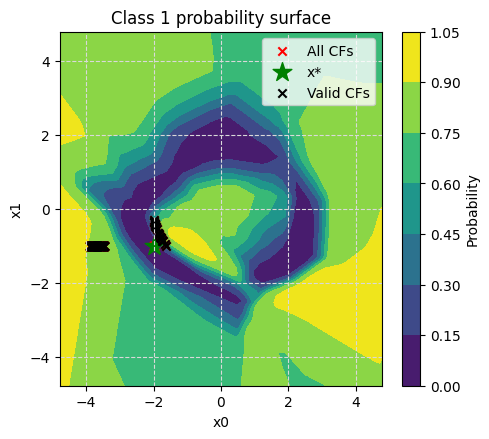

In [72]:

# -----------------------------
# 4) Post-processing & plots
# -----------------------------
# With prob-based validity, use threshold instead of ==0.
# valid_mask = F_mmo[:, 0] < 0.05  # e.g. at least 95% target prob
# valid_F = F_mmo[valid_mask]
# valid_X = X_mmo[valid_mask]

# plt.figure()
# plt.scatter(X[:, 0], X[:, 1], c=Y, label="Original data", s=15, cmap="coolwarm")
# plt.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
# plt.scatter(valid_X[:, 0], valid_X[:, 1], c="black", marker="x", label="Valid CFs")
# plt.scatter(x_star[0].item(), x_star[1].item(),
#             c="green", marker="*", s=200, label="x*")
# plt.legend()
# plt.show()


fig,ax=plot_proba(model, X,levels=6)
ax.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
ax.scatter(x_star[0].item(), x_star[1].item(),
           c="green", marker="*", s=200, label="x*")
# scatter valid CFs if any
if valided_X_mmo.shape[0] > 0:
    ax.scatter(valided_X_mmo[:, 0], valided_X_mmo[:, 1],
               c="black", marker="x", label="Valid CFs")

ax.legend()
plt.show()

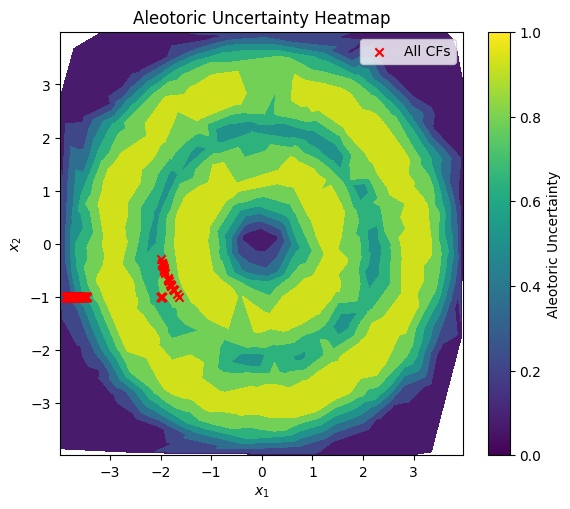

In [80]:
# draw AU heatmap with valid CFs
AU= Aleotoric_Uncertainty_prob(boundary_focus_prob)

plt.figure(figsize=(6.5, 5.5))
plt.tricontourf(X[:, 0], X[:, 1], AU(X), levels=5, cmap="viridis")
plt.scatter(X_mmo[:, 0], X_mmo[:, 1], c="red", marker="x", label="All CFs")
plt.colorbar(label=r"Aleotoric Uncertainty")
plt.title("Aleotoric Uncertainty Heatmap")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

In [39]:
poi=np.array([4,2.6676])
problem.objs[1](poi), x_star

(0.763017864571254, tensor([-3.5000, -2.0000], device='cuda:0'))

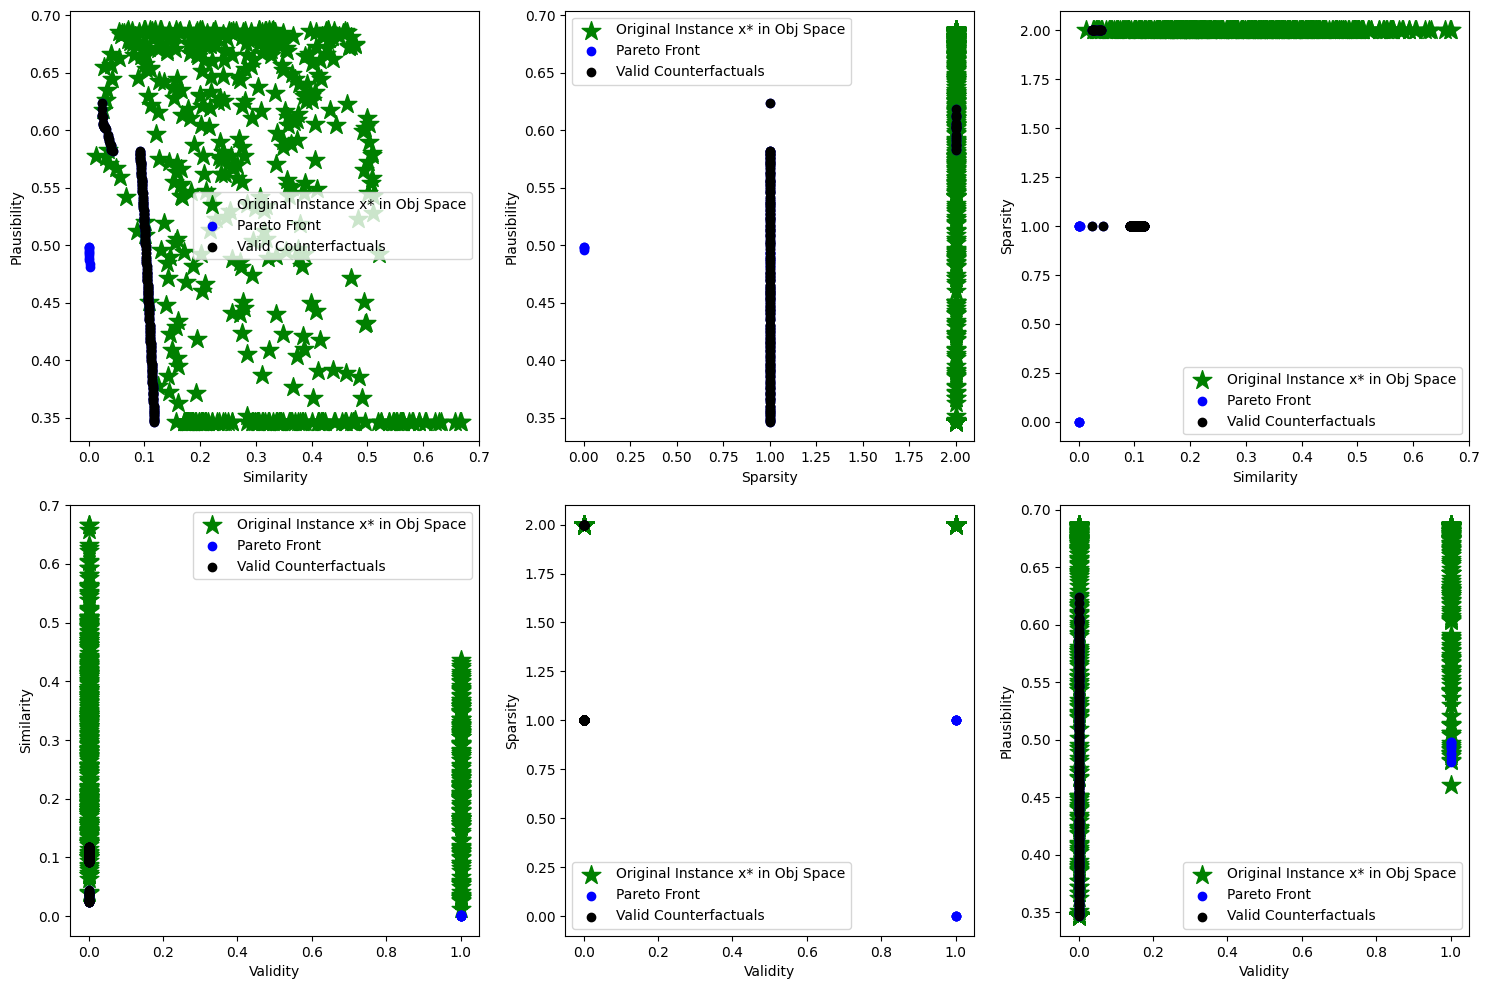

In [73]:
# visualize the Pareto front in objective space
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Create pairs of objective indices to plot
obj_pairs = [(1, 3), (2, 3), (1, 2), (0, 1), (0, 2), (0, 3)]
obj_labels = ['Validity', 'Similarity', 'Sparsity', 'Plausibility']

for i, (obj_x, obj_y) in enumerate(obj_pairs):
    row = i // 3
    col = i % 3
    ax[row, col].scatter(problem.evaluate(X)[:, obj_x],
                         problem.evaluate(X)[:, obj_y],
                         marker='*', c='green', s=200, label='Original Instance x* in Obj Space')
    ax[row, col].scatter(F_mmo[:, obj_x], F_mmo[:, obj_y], c='blue', label='Pareto Front')
    ax[row, col].scatter(valided_F_mmo[:, obj_x], valided_F_mmo[:, obj_y], c='black', label='Valid Counterfactuals')
    ax[row, col].set_xlabel(obj_labels[obj_x])
    ax[row, col].set_ylabel(obj_labels[obj_y])
    ax[row, col].legend()

plt.tight_layout()
plt.show()

In [74]:
import plotly.graph_objects as go

F_X = problem.evaluate(X)

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=problem.evaluate(X)[:,1], y=problem.evaluate(X)[:,2], z=problem.evaluate(X)[:,3],
    mode='markers',
    marker=dict(color='green', size=6, opacity=0.2),
    name='Original observations in Obj Space'
))

fig.add_trace(go.Scatter3d(
    x=not_valided_F_mmo[:,1], y=not_valided_F_mmo[:,2], z=not_valided_F_mmo[:,3],
    mode='markers',
    marker=dict(color='blue', size=3, opacity=0.2),
    name='Pareto Front which not valid'
))

fig.add_trace(go.Scatter3d(
    x=valided_F_mmo[:,1], y=valided_F_mmo[:,2], z=valided_F_mmo[:,3],
    mode='markers',
    marker=dict(color='red', size=5, symbol='cross'),
    name='Valid Counterfactuals in Obj Space'
))


# add the fixed x_star point
fig.add_trace(go.Scatter3d(
    x=[problem.evaluate(x_star.detach().cpu().numpy().astype(np.float32))[1]],
    y=[problem.evaluate(x_star.detach().cpu().numpy().astype(np.float32))[2]],
    z=[problem.evaluate(x_star.detach().cpu().numpy().astype(np.float32))[3]],
    mode='markers',
    marker=dict(color='purple', size=6),
    name='Factual Instance x* in Obj Space'
))

fig.update_layout(
    scene=dict(
        xaxis_title='similarity/AU',
        yaxis_title='sparsity',
        zaxis_title='plausibility'
    ),
    width=900, height=700
)

fig.show()

# 可选：保存成可交互 html
fig.write_html("pareto_front_3d.html")
